# Solve an optimization problem using a parametric NLIW model

## Necessary data

 - Tidal amplitude at a point
 - Stratification parameters $\alpha$ and $c$.
 - Time series of NLIW amplitude, $A$
 
## Models

The optimization problem has the form

$$
A(t) = \hat{A}(t) a_0(t-\hat{T}(t))
$$

where $\hat{A}(t)$ is an amplitude distortion function, $a_0(t)$ is the initial internal tide amplitude, $\hat{T}(t)$ is a time lag function. The amplitude and time lag functions are determined empirically from ~O(10$^5$) KdV model solutions and are found to be functions of $\hat{L}$, the nondimensional steepening length scale, $L_s/L$, where 
$$
L_s = \frac{c^2}{\alpha \omega a_0}
$$
and $L$ is the distance from the generation site or the 'equivalent deep-water' site. This is the important link that we have identified. The amplitude function is

$$
\hat{A}(t) = \frac{A_{max}}{a_0} = f(\hat{L}) = -A_{h} + 0.5(A_h - A_l)\left(
    1+ \tanh\left( \frac{\hat{L} - L_A}{0.5\delta_{lA}}\right) \right)
$$

$$
\hat{A}(t) = \frac{A_{max}}{a_0} = f(\hat{L}) = 
$$
where $A_h$, $A_l$, $L_A$, $\delta_{lA}$ are all emirically determined parameters.  Similarly, the time lag function is

$$
\hat{T}(t) = \frac{T_{max} c}{L} =  f(\hat{L}) = -T_{h} + 0.5(T_h - T_l)\left(
    1+ \tanh\left( \frac{\hat{L} - L_T}{0.5\delta_{lT}}\right) \right)
$$
that also has four unknown parameters $T_h$, $T_l$, $L_T$, $\delta_{lT}$. The dimensional maximum amplitude, $A_{max}$, and time of maximum amplitude, $T_{max}$, are extracted from the KdV solutions and the parametric variables are found via...(least-squares, Bayesian inference...). 

The initial internal tide amplitude is unknown and we assume a linear relationship to the tidal elevation envelope, specifically

$$
a_0(t) = \beta_0 + \beta_1 \hat{\zeta}(t - \hat{T}(t))+\epsilon
$$
where $\hat{\zeta}$ is the analytical amplitude envelope of the tidal elevation signal, $\zeta(t)$, which is obtained from the OSU Indonesian Seas tidal model i.e. TPXO (REF).
The problem is to determine the parameters $\beta_0$ and $\beta_1$ and characterize the error, $\epsilon$. The error term is a crude way of incorporating unknown processes that alter the initial wave amplitude e.g., remote internal waves, mesoscale amplitude modulation, and generation modulation.




In [2]:
# Load the libraries
import h5py
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

from scipy import signal
from scipy.optimize import minimize

from soda.utils.timeseries import timeseries, skill, rmse
from soda.utils.uspectra import uspectra, getTideFreq
from soda.utils.othertime import SecondsSince, TimeVector
from soda.dataio.conversion import readotps
from soda.utils.myairsea import pol2cart

from glob import glob

In [3]:
%matplotlib notebook

# Load the tidal amplitude data

In [4]:
# Load the tidal amplitude
##########
# Inputs
xpt, ypt = 123.346383, -13.75895

# Grab the barotropic tide data
tidemod = '/home/suntans/Share/ScottReef/DATA/TIDES/Ind2016/Model_Ind_2016'
tidecons = ['M2','S2','N2','K2','K1','O1','P1','Q1']

time = TimeVector('20160501.000000','20170501.000000',3600)

basetime = datetime(2016,1,1)
##########
# Extract the tidal height for the whole period
eta, U,V = readotps.tide_pred(tidemod,np.array([xpt]),
                        np.array([ypt]),time)

# Manually compute the amp and phase that includes the nodal corrections
eta_ts = timeseries(time,eta)

eta_amp, eta_phs, omega,_,eta_harmonic,_=eta_ts.tidefit(frqnames=tidecons,basetime=basetime)

h_re, h_im = pol2cart(eta_phs.data, eta_amp.data)
nf = len(omega)
beta_s = np.zeros((2*nf,))
beta_s[0:-1:2] = h_re.ravel()
beta_s[1::2] = h_im.ravel()

beta_s

Interpolating consituent: M2...


/home/suntans/code/soda/soda/dataio/conversion/readotps.py:325: RuntimeWarning: divide by zero encountered in true_divide
  tmp_u_re /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:325: RuntimeWarning: invalid value encountered in true_divide
  tmp_u_re /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:326: RuntimeWarning: divide by zero encountered in true_divide
  tmp_u_im /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:326: RuntimeWarning: invalid value encountered in true_divide
  tmp_u_im /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:327: RuntimeWarning: divide by zero encountered in true_divide
  tmp_v_re /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:327: RuntimeWarning: invalid value encountered in true_divide
  tmp_v_re /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:328: RuntimeWarning: divide by zero encountered in true_divide
  tmp_v_im /= depth
/home/sun

Interpolating consituent: S2...
Interpolating consituent: N2...
Interpolating consituent: K2...
Interpolating consituent: K1...
Interpolating consituent: O1...
Interpolating consituent: P1...
Interpolating consituent: Q1...


/home/suntans/code/soda/soda/utils/harmonic_analysis.py:139: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,y)


array([-1.06509122, -0.73217239, -0.37533113,  0.61863875,  0.21996617,
       -0.03981784,  0.03631467, -0.15276493, -0.23136769,  0.0536182 ,
        0.10304469, -0.08413635, -0.07918459, -0.00313358, -0.01240162,
        0.02753476])

# Load the observed amplitude data

In [5]:
###########
ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/KP150_Fitted_Buoyancy_wout_motion.nc'
mode = 0
###########

ds1 = xr.open_dataset(ncfile,group='KP150_phs1')
ds2 = xr.open_dataset(ncfile,group='KP150_phs2')

# Merge the two

A_n = xr.concat([ds1['A_n'][:,mode],ds2['A_n'][:,mode]], dim='time')
#a0 = xr.concat([ds1['amp'][:,mode,0],ds2['amp'][:,mode,0]], dim='timeslow')

# Quality control
A_n.loc['2016-09-18':'2016-10-31']=np.nan


# Create a time series of single days with the max amplitude 
time1 = pd.date_range('2016-5-1','2016-9-15') 
time2 = pd.date_range('2016-11-1','2017-5-1')
time = time1.append(time2)

#time = pd.date_range('2017-1-1','2017-4-20') 



<IPython.core.display.Javascript object>


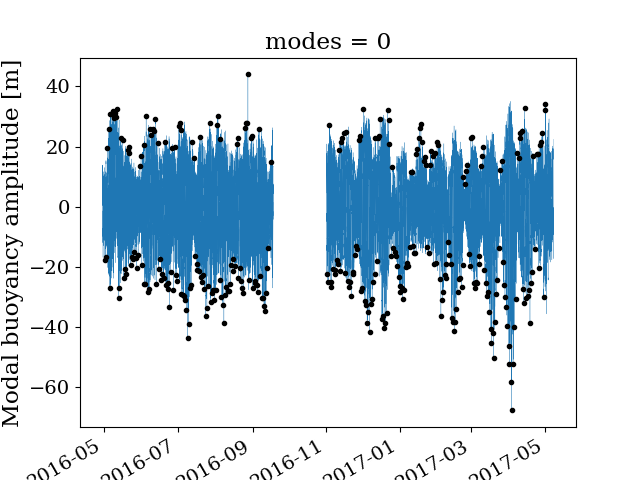

In [6]:
# Find the A_max over one day blocks
def maximum_amplitude_finder(amp_signal):
    amp_min = np.min(amp_signal)
    amp_max = np.max(amp_signal)
    if np.abs(amp_min)>amp_max:
        return amp_min, np.argwhere(amp_signal==amp_min)[0][0]
    else:
        return amp_max, np.argwhere(amp_signal==amp_max)[0][0]

Amax_all = []
Amax_time = []
for t1 in time:
    t2 = t1 + np.timedelta64(1,'D')
    
    Amax, tidx = maximum_amplitude_finder(A_n.sel(time=slice(t1,t2)).values)
    tmax = A_n.sel(time=slice(t1,t2)).time[tidx].values
    Amax_all.append(Amax)
    Amax_time.append(tmax)

#ds_A = pd.Series(Amax_all, index=Amax_time)
ds_A = xr.DataArray(Amax_all, coords={'time':Amax_time}, dims=('time',))

plt.figure()
A_n.plot(lw=0.2)
plt.plot(ds_A['time'], ds_A.values,'k.')

# Load the stratification data

In [23]:
#ds_S = xr.open_dataset('../inputs/Crux_KP150_12mth_Density_lowpass_nliw.nc')
#ds_S['time'] += np.timedelta64(1,'D')

datadir = '../../run_ddcurves/DATA_SHELL/'
#ds_S = xr.open_dataset('%s/ShellCrux_Uniltered_Density_BHM_VI_20162017_nliw.nc'%datadir,)
ds_S = xr.open_dataset('../../run_ddcurves/DATA_SHELL/ShellCrux_Uniltered_Density_BHM_VI_20162017_vkdv_nliw.nc')
# Offset the time by one day
ds_S['time'] += np.timedelta64(1,'D')

#datadir = '../../run_ddcurves/DATA_SHELL/'
#ds_S = xr.open_dataset('%s/ShellCrux_Filtered_Density_BHM_MCMC_20162017_nliw.nc'%datadir,)
# Offset the time by one day
#ds_S['time'] += np.timedelta64(1,'D')

ds_S


<xarray.Dataset>
Dimensions:   (ensemble: 500, params: 6, time: 374)
Coordinates:
  * time      (time) datetime64[ns] 2016-04-30T23:15:00 ... 2017-05-08T06:40:00
  * ensemble  (ensemble) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * params    (params) int64 0 1 2 3 4 5
Data variables:
    cn        (time, ensemble) float64 ...
    alpha     (time, ensemble) float64 ...
    beta      (params, time, ensemble) float64 ...
    cn_mu     (time, ensemble) float64 ...
    alpha_mu  (time, ensemble) float64 ...

# Functions

 - ~~calc L_hat~~
 - ~~calc a_0~~
 - ~~calc zeta_hat (tidal amplitude envelope)~~
 - ~~extract alpha and c from stratification~~
 - ~~calc A_hat~~
 - ~~calc T_hat~~
 - Compute difference between A_hat  and A_observed

In [24]:
def sine_model_envelope_pm(beta_s, ff, t):
    n = len(ff)
    
    #result = t*0
    
    result = tt.zeros(t.shape)

    for ii in range(0,n):
        result += beta_s[2*ii]*pm.math.cos(ff[ii] * t) + beta_s[2*ii+1]*pm.math.sin(ff[ii]*t)
        
    # Compute the imaginary part by adding a 90 degree phase shift
    #result_i = t*0
    result_i = tt.zeros(t.shape)

    for ii in range(0,n):
        result_i += beta_s[2*ii]*pm.math.cos(ff[ii] * t + np.pi/2) \
            + beta_s[2*ii+1]*pm.math.sin(ff[ii]*t + np.pi/2)
    
    return pm.math.sqrt(result*result + result_i*result_i)

def sine_model_envelope(beta_s, ff, t):
    n = len(ff)
    
    zeros = np.zeros
    cos = np.cos
    sin = np.sin
    
    result = zeros(t.shape)

    for ii in range(0,n):
        result += beta_s[2*ii]*cos(ff[ii] * t) + beta_s[2*ii+1]*sin(ff[ii]*t)
        
    # Compute the imaginary part by adding a 90 degree phase shift
    #result_i = t*0
    result_i = zeros(t.shape)

    for ii in range(0,n):
        result_i += beta_s[2*ii]*cos(ff[ii] * t + np.pi/2) \
            + beta_s[2*ii+1]*sin(ff[ii]*t + np.pi/2)
    
    return np.sqrt(result*result + result_i*result_i)

def calc_Ls(a0, omega, c, alpha):
    return c*c / (a0*omega*alpha)

def calc_Lhat(a0, omega, c, alpha, L):
    return calc_Ls(a0, omega, c, alpha) / L

def calc_zetahat(beta, omega, t):
    return sine_model_envelope(beta, omega, t)
    
def calc_a0(beta, zetahat):
    return beta[0] + beta[1]*zetahat

def calc_Ahat_That(Lhat, coeffs):
    Ah, Al, LA, dLA = coeffs
    return -Ah + 0.5*(Ah-Al) * (1 + np.tanh( (Lhat-LA)/(0.5*dLA)) )

def calc_Ahat_That_new(Lhat, coeffs):
    Ah, Al, LA, dLA = coeffs
    idx = Lhat<0
    Ahat = np.zeros_like(Lhat)
    Ahat[idx] = -Ah + 0.5*(Ah-Al) * (1 - np.tanh( (Lhat[idx]+LA)/(0.5*dLA)) ) 
    Ahat[~idx] = -1*(-Ah + 0.5*(Ah-Al) * (1 + np.tanh( (Lhat[~idx]-LA)/(0.5*dLA)) ) )
    return Ahat


def calc_Ahat_quadratic(Lhat, coeffs):
    a0, a1, x0  = coeffs
    #Ahat= a0+(amax-a0)*np.exp(-((Lhat-x0)/dx)**2.)
    am = (-a1-a0)/(-1-x0)**2
    Ahat = am*(Lhat-x0)**2+a0
    Ahat[Lhat<-1] = -a1
    
    idx = Lhat > 0
    Ahat[idx] = -am*(Lhat[idx]+x0)**2-a0
    Ahat[Lhat>1] = a1


    return Ahat

def calc_That_quadratic(Lhat, coeffs):
    a0, a1,  x0  = coeffs
    #Ahat= a0+(amax-a0)*np.exp(-((Lhat-x0)/dx)**2.)
    am = (-a1+a0)/(-1-x0)**2
    Ahat = -am*(Lhat-x0)**2+a0
    Ahat[Lhat<-1] = a1
    
    idx = Lhat > 0
    Ahat[idx] = -am*(Lhat[idx]+x0)**2+a0
    Ahat[Lhat>1] = a1
    
    return Ahat


def calc_tlag(That, c, L):
    return L*That/c

def calc_tlag_nonlinear(That, c, L, alpha, A):
    c_nl = c+alpha*A
    return L*That/c_nl

def extract_alpha_c(ds, t):
    dsC = ds.sel(time=t, method='bfill')  
    nsamples = dsC.dims['ensemble']
    nt = dsC.dims['time']

    randint = np.random.randint(nsamples,size=nt)
    alpha = dsC.alpha_mu.values[range(nt),randint]
    cn= dsC.cn_mu.values[range(nt),randint]
    return alpha, cn

def extract_alpha_c_min(ds, t):
    dsC = ds.sel(time=t, method='nearest')  
    nsamples = dsC.dims['ensemble']
    nt = dsC.dims['time']

    alpha = dsC.alpha.values.min(axis=1)
    
    cn = np.zeros((nt,))
    for ii in range(nt):
        idx = np.argwhere(dsC.alpha.values[ii,:] == alpha[ii])[0,0]
        cn[ii]= dsC.cn.values[ii,idx]
    return alpha, cn



In [40]:
# Compute a0 for a given beta_0, beta_1 pair
# Needs to be computed iteratively

timein = ds_A.time.values
#timein = pd.date_range('2017-1-1','2017-4-20') 

timeinsec = SecondsSince(timein, basetime=basetime)
nt = timein.shape[0]
Amax_obs = ds_A.sel(time=timein, method='nearest')
#Amax_obs[Amax_obs>0] = -1*Amax_obs[Amax_obs>0]

# Givens
L = 1.015e5 # Length scale
#L = 7e5 # Length to indonesia (based on a mode-1 wave taking 5 days at 1.6 m/s)
omega0 = omega[0] # M2

# Need to guess That and beta
#Ahat_args = (3.0, 1.0, 1.0, 0.15)
#That_args = (-0.5, -1.0, 1.0, 0.30)

#Ahat_args= (-2.68,-0.54)
#That_args = (1.9,1.4,-0.34)

Ahat_args = (-2.68,1.25,-0.65)
That_args = (1.95,1.5,-0.1)


##
# Start of loop...

def compute_Ahat(beta, alpha, cn, L):

    That = np.zeros((nt,))
    a0 = np.zeros((nt,))
    
    for ii in range(6):

        # Compute the time lag
        #tlag = calc_tlag(That, cn, L)
        tlag = calc_tlag_nonlinear(That, cn, L, alpha, a0)


        # Compute a_0
        zetahat = calc_zetahat(beta_s, omega, timeinsec - tlag)
        a0 = calc_a0(beta, zetahat)
        
        # a0 needs to be the same sign as alpha
        #a0 *= np.sign(alpha)

        # Compute Ahat, Lhat
        Lhat = calc_Lhat(a0, omega0, cn, alpha, L)
        #Ahat = calc_Ahat_That_new(Lhat, Ahat_args)
        #That = calc_Ahat_That_new(Lhat, That_args)
        
        Ahat = calc_Ahat_quadratic(Lhat, Ahat_args)
        That = calc_That_quadratic(Lhat, That_args)
        
        Amax = a0*Ahat
        
    return Lhat, That, Ahat, a0
    

def compute_Amax(beta, alpha, cn, L):
    # Get alpha, c
    Lhat, That, Ahat, a0 = compute_Ahat(beta, alpha, cn, L)

    return Ahat*a0

def compute_Amax_Aobs(beta, alpha, cn, L, Amax_obs):
    
    Amax_guess = compute_Amax(beta, alpha, cn, L)

    # Need to change the sign of the observed Amax to suit alpha
    my_Amax = 1*Amax_obs
    
    #signA = np.sign(Amax_guess)
    #signalpha= np.sign(alpha)
    #idx = signA != signalpha
    #Amax_guess[idx] = -1*Amax_guess[idx]
    
    #signA = np.sign(my_Amax)
    #signalpha= np.sign(alpha)
    #idx = signA != signalpha
    #my_Amax[idx] = -1*my_Amax[idx]
    
    return Amax_guess, my_Amax

def compute_Amax_error(beta, L,alpha, cn, Amax_obs):
    
    beta_a = [beta[0],beta[1]]
    #L = beta[2]*1e6
    
    Amax_guess, my_Amax = compute_Amax_Aobs(beta_a, alpha, cn, L, Amax_obs)
    
    # Compute the error
    #err = np.linalg.norm(my_Amax - Amax_guess)
    
    # Compute a weighted sum
    weight = my_Amax**3/np.sum(my_Amax**3)
    err = np.linalg.norm(weight*(my_Amax - Amax_guess))

    return err


#alpha, cn = extract_alpha_c(ds_S, timein)

#print(compute_Amax_error(beta0, alpha, cn, Amax_obs))




In [41]:
# Optimize to find beta's for a given alpha, cn
#alpha, cn = extract_alpha_c_min(ds_S, timein)
alpha, cn = extract_alpha_c(ds_S, timein) # Random selection


# Make sure alpha's sign aligns with the max or else we will never get convergence
signA = np.sign(Amax_obs)
signalpha= np.sign(alpha)
idx = signA != signalpha
my_Amax = 1*Amax_obs
my_Amax[idx] = -1*my_Amax[idx]

beta0 = [0.,0.,]

soln = minimize(compute_Amax_error, beta0, args = (L, alpha, cn, my_Amax),
               bounds=((0,1),(1,25),),)
soln

      fun: 2.086750568415303
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.02635234e-02, -1.60316205e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 48
      nit: 9
   status: 0
  success: True
        x: array([ 1.        , 12.19677007])

In [38]:
# Compute length scale to indonesia
Lextra = 1e6
Lequiv = cn.mean()*(5*86400)
Lequiv


721658.7568085185

<IPython.core.display.Javascript object>


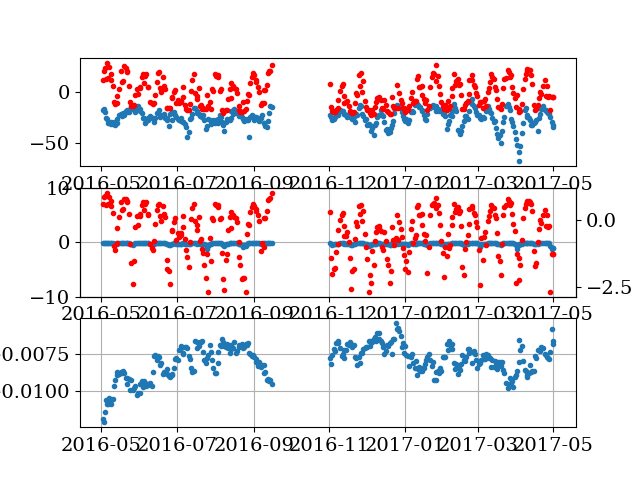

In [39]:
#Amax_guess = compute_Amax(soln['x'], alpha, cn)
#soln['x'] = [2,10.2,0.23]

Amax_guess, my_Amax = compute_Amax_Aobs(soln['x'][0:2], alpha, cn,  L,my_Amax)
Lhat, That, Ahat, a0 = compute_Ahat(soln['x'][0:2], alpha, cn, L)

plt.figure()
ax=plt.subplot(311)
plt.plot(timein, my_Amax,'.')
plt.plot(timein, Amax_guess,'r.')
#plt.plot(timein, a0,'g.')


plt.subplot(312,sharex=ax)
plt.plot(timein[Lhat<0], Lhat[Lhat<0],'.')
plt.plot(timein[Lhat>0], Lhat[Lhat>0],'.')

plt.ylim(-10,10)
plt.grid(b=True)

ax2 = plt.twinx()
ax2.plot(timein, Ahat,'r.')

plt.subplot(313,sharex=ax)
plt.plot(timein,alpha,'.')
plt.grid(b=True)


In [28]:
# Compute the solutions many times
niters = 500
betaa0 = np.zeros((niters,2))
Amax_optimal = np.zeros((niters,nt))
a0_optimal = np.zeros((niters,nt))
for ii in range(niters):
    alpha, cn = extract_alpha_c(ds_S, timein)
    
    # Make sure alpha's sign aligns with the max or else we will never get convergence
    signA = np.sign(Amax_obs)
    signalpha= np.sign(alpha)
    idx = signA != signalpha
    my_Amax = Amax_obs.copy()
    my_Amax[idx] = -1*my_Amax[idx]

    beta0 = [0.,0., ]

    soln = minimize(compute_Amax_error, beta0, args = (L,alpha, cn, my_Amax),
                   bounds=((0,5),(1,25),))
    
    Amax_guess, _ = compute_Amax_Aobs(soln['x'][0:2], alpha, cn, L, my_Amax)
    
    betaa0[ii,:] =soln['x']
    
    _, _, _, a0_optimal[ii,:] = compute_Ahat(soln['x'], alpha, cn, L)
    
    Amax_optimal[ii,:] = Amax_guess
    
    print(ii,soln['x'], soln['fun'])

0 [ 5.         10.11694351] 2.0413097648887173
1 [ 5.         10.24676277] 2.0531951377200373
2 [5.         9.92599739] 2.0400942635521404
3 [ 5.         10.36271376] 2.056043985459145
4 [ 5.         10.01169574] 2.0416054804560555
5 [ 5.        10.0279777] 2.0325261457024824
6 [5.         9.76658503] 2.035006239530373
7 [ 5.         10.04814674] 2.038985758653342
8 [ 5.         10.19986048] 2.049580738296369
9 [ 5.        10.0137526] 2.04227430525411
10 [ 5.         10.33171821] 2.0502182131466626
11 [5.         9.98723062] 2.045507496455306
12 [ 5.         10.00706293] 2.0409251457443682
13 [5.         9.74537668] 2.037658157386348
14 [ 5.         10.22417662] 2.048353982094403
15 [5.         9.89091466] 2.0398038534406817
16 [ 5.         10.20806645] 2.0566538576120483
17 [ 5.         10.18811476] 2.061107923373585
18 [ 5.         10.26650854] 2.0685747263188268
19 [ 5.         10.12777141] 2.0401315414641217
20 [ 5.         10.12437866] 2.048627788304102
21 [ 5.         10.30285887

175 [5.         9.92102949] 2.0334949986601476
176 [ 5.         10.69789748] 2.0829833884335467
177 [5.         9.91475747] 2.040412276531203
178 [ 5.         10.06323054] 2.026088349957085
179 [5.         9.93164926] 2.037097689697701
180 [ 4.85111917 10.23981559] 2.0399269085966147
181 [ 5.         10.09875111] 2.0431170983062286
182 [5.         9.89268822] 2.044171496261796
183 [5.         9.75925228] 2.039210827725027
184 [ 5.         10.03889854] 2.038697576108204
185 [ 5.         10.23513177] 2.060758632858835
186 [5.         9.79979743] 2.0352847926457067
187 [ 5.         10.06895616] 2.049377838029284
188 [ 5.         10.07200461] 2.05143821953287
189 [ 5.        10.0175123] 2.033945078068891
190 [ 5.         10.43508429] 2.0689777939608036
191 [5.        9.9135596] 2.0383165630387614
192 [5.         9.85520352] 2.03509771620325
193 [5.         9.92354376] 2.035365973218248
194 [ 5.         10.17523909] 2.043124536038097
195 [5.         9.92115935] 2.046438069116896
196 [5.    

348 [5.         9.92510086] 2.0436166022591147
349 [5.         9.76392961] 2.0413039434338875
350 [ 5.         10.25577069] 2.0522114535063256
351 [5.         9.87414468] 2.0386765506103526
352 [ 5.         10.13943815] 2.0473130406871913
353 [ 5.         10.46256568] 2.0841408752089627
354 [5.         9.94730433] 2.0381507726659716
355 [ 5.         10.04910498] 2.040783397042928
356 [5.        9.7043381] 2.046743254545312
357 [5.         9.93473837] 2.0494320814085087
358 [ 5.         10.20611456] 2.0473270302957367
359 [ 5.         10.05399873] 2.031453163429474
360 [ 5.         10.06011845] 2.0391179411003204
361 [ 5.        10.1001435] 2.0525563806337326
362 [ 5.         10.04826897] 2.056779797041997
363 [5.         9.92039866] 2.031168727705684
364 [ 5.         10.20097043] 2.0465701356395427
365 [5.         9.91150708] 2.0314388129273335
366 [ 4.38976155 10.37805732] 2.0619608349014626
367 [5.        9.9515768] 2.0358773917664585
368 [ 5.         10.06217062] 2.032438036346115
3

<IPython.core.display.Javascript object>


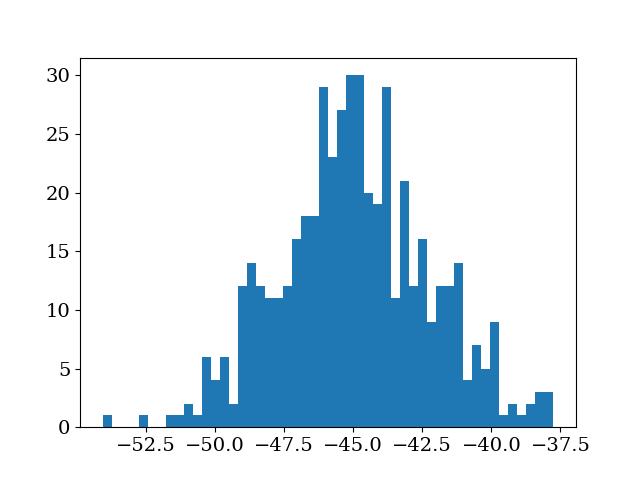

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  2.,  1.,  6.,  4.,
         6.,  2., 12., 14., 12., 11., 11., 12., 16., 18., 18., 29., 23.,
        27., 30., 30., 20., 19., 29., 11., 21., 12., 16.,  9., 12., 12.,
        14.,  4.,  7.,  5.,  9.,  1.,  2.,  1.,  2.,  3.,  3.]),
 array([-54.0677101 , -53.7414482 , -53.4151863 , -53.0889244 ,
        -52.7626625 , -52.4364006 , -52.1101387 , -51.7838768 ,
        -51.4576149 , -51.131353  , -50.80509111, -50.47882921,
        -50.15256731, -49.82630541, -49.50004351, -49.17378161,
        -48.84751971, -48.52125781, -48.19499591, -47.86873401,
        -47.54247211, -47.21621021, -46.88994831, -46.56368641,
        -46.23742451, -45.91116261, -45.58490071, -45.25863881,
        -44.93237691, -44.60611501, -44.27985312, -43.95359122,
        -43.62732932, -43.30106742, -42.97480552, -42.64854362,
        -42.32228172, -41.99601982, -41.66975792, -41.34349602,
        -41.01723412, -40.69097222, -40.36471032, -40.03844842,
        -39.

In [29]:
plt.figure()
plt.hist(Amax_optimal[:,285],bins=50)
#plt.plot(alpha)

<IPython.core.display.Javascript object>


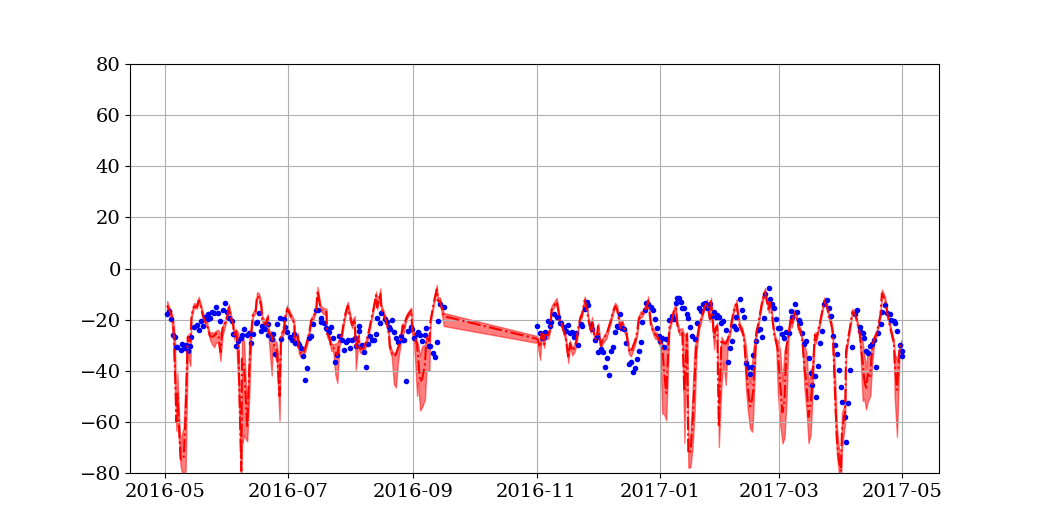

(-80, 80)

In [30]:
plt.figure()
#ax=plt.subplot(211)
plt.plot(timein, my_Amax,'b.')
plt.plot(timein, np.median(Amax_optimal,axis=0),'r-.')
#plt.plot(timein, np.max(Amax_optimal,axis=0),'r+')
#plt.plot(timein, np.min(Amax_optimal,axis=0),'r+')
plt.fill_between(timein, np.min(Amax_optimal,axis=0),
            np.max(Amax_optimal,axis=0) ,color='r' ,alpha=0.5   )
#
#plt.fill_between(timein, np.percentile(Amax_optimal,1,axis=0),
#            np.percentile(Amax_optimal,99,axis=0)     )

plt.grid(b=True)
plt.ylim(-80,80)

<IPython.core.display.Javascript object>


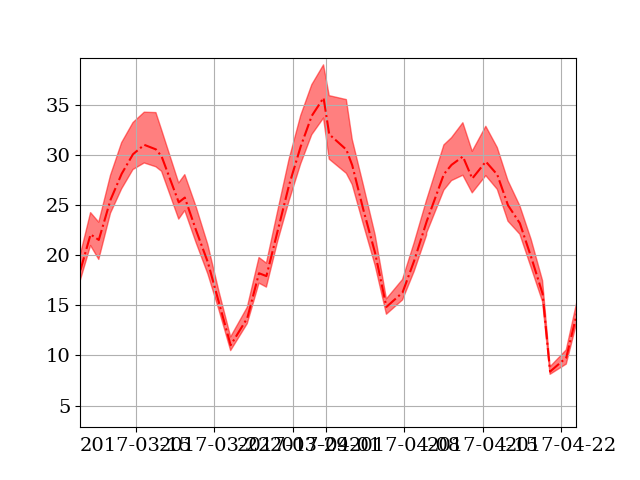

(0, 40)

In [73]:
plt.figure()
#ax=plt.subplot(211)
#plt.plot(timein, my_Amax,'b.')
plt.plot(timein, np.median(a0_optimal,axis=0),'r-.')
#plt.plot(timein, np.max(Amax_optimal,axis=0),'r+')
#plt.plot(timein, np.min(Amax_optimal,axis=0),'r+')
plt.fill_between(timein, np.min(a0_optimal,axis=0),
            np.max(a0_optimal,axis=0) ,color='r' ,alpha=0.5   )
#
#plt.fill_between(timein, np.percentile(Amax_optimal,1,axis=0),
#            np.percentile(Amax_optimal,99,axis=0)     )

#ax2 = plt.twinx()

plt.grid(b=True)
plt.ylim(0,40)

<IPython.core.display.Javascript object>


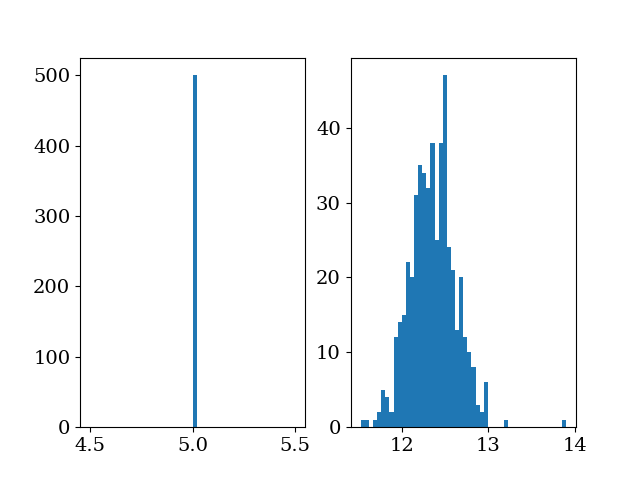

(array([ 1.,  1.,  0.,  1.,  2.,  5.,  4.,  2., 12., 14., 15., 22., 20.,
        31., 35., 34., 32., 38., 25., 38., 47., 24., 21., 13., 20., 12.,
        10.,  8.,  3.,  2.,  6.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([11.5279303 , 11.57524985, 11.6225694 , 11.66988895, 11.71720851,
        11.76452806, 11.81184761, 11.85916716, 11.90648671, 11.95380627,
        12.00112582, 12.04844537, 12.09576492, 12.14308447, 12.19040403,
        12.23772358, 12.28504313, 12.33236268, 12.37968223, 12.42700179,
        12.47432134, 12.52164089, 12.56896044, 12.61628   , 12.66359955,
        12.7109191 , 12.75823865, 12.8055582 , 12.85287776, 12.90019731,
        12.94751686, 12.99483641, 13.04215596, 13.08947552, 13.13679507,
        13.18411462, 13.23143417, 13.27875372, 13.32607328, 13.37339283,
        13.42071238, 13.46803193, 13.51535149, 13.56267104, 13.60999059,
        13.65731014, 13.70462969, 13.75194925, 13.7992688 ,

In [74]:
plt.figure()
plt.subplot(121)
plt.hist(betaa0[:,0], bins=50)

plt.subplot(122)
plt.hist(betaa0[:,1], bins=50)

#plt.subplot(133)
#plt.hist(betaa0[:,2], bins=50)

In [293]:
# Output the beta terms for later prediciton
outputh5 = '../inputs/a0_betas_Crux.h5'
f = h5py.File(outputh5,'w')
g = f.create_group('data')
g.create_dataset('a0-beta',data=betaa0)
f.close()

<IPython.core.display.Javascript object>


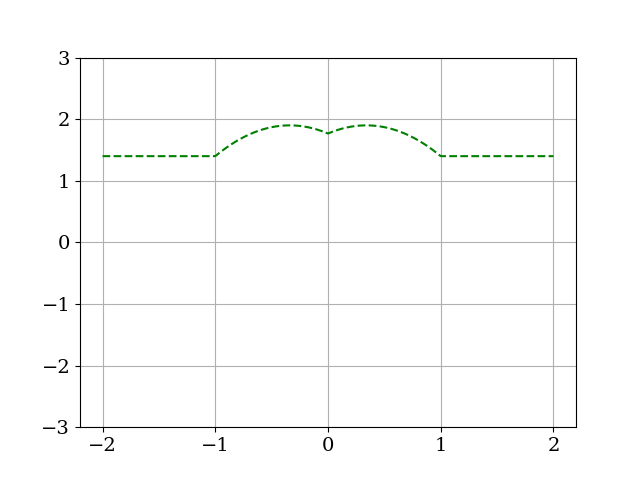

In [239]:
# Test the A_hat function
Lhat = np.linspace(-2,2,500)
def calc_Ahat_That_new(Lhat, coeffs):
    Ah, Al, LA, dLA = coeffs
    idx = Lhat<0
    Ahat = np.zeros_like(Lhat)
    Ahat[idx] = -Ah + 0.5*(Ah-Al) * (1 - np.tanh( (Lhat[idx]+LA)/(0.5*dLA)) ) 
    Ahat[~idx] = -1*(-Ah + 0.5*(Ah-Al) * (1 + np.tanh( (Lhat[~idx]-LA)/(0.5*dLA)) ) )
    return Ahat

def calc_Ahat_quadratic(Lhat, coeffs):
    a0,  x0  = coeffs
    #Ahat= a0+(amax-a0)*np.exp(-((Lhat-x0)/dx)**2.)
    am = (-1-a0)/(-1-x0)**2
    Ahat = am*(Lhat-x0)**2+a0
    Ahat[Lhat<-1] = -1
    
    idx = Lhat > 0
    Ahat[idx] = -am*(Lhat[idx]+x0)**2-a0
    Ahat[Lhat>1] = 1


    return Ahat

def calc_That_quadratic(Lhat, coeffs):
    a0, a1,  x0  = coeffs
    #Ahat= a0+(amax-a0)*np.exp(-((Lhat-x0)/dx)**2.)
    am = (-a1+a0)/(-1-x0)**2
    Ahat = -am*(Lhat-x0)**2+a0
    Ahat[Lhat<-1] = a1
    
    idx = Lhat > 0
    Ahat[idx] = -am*(Lhat[idx]+x0)**2+a0
    Ahat[Lhat>1] = a1


    return Ahat


#Ahat = calc_Ahat_That_new(Lhat, Ahat_args)
#Ahat_g = calc_Ahat_quadratic(Lhat,(-2.68,-0.54))
Ahat_g = calc_That_quadratic(Lhat,(1.9,1.4,-0.34))


plt.figure()
#plt.plot(Lhat,Ahat,'r--')
                                 
plt.plot(Lhat,Ahat_g,'g--')
plt.ylim(-3,3)
plt.grid(b=True)